# Pirate Pain Detection Pipeline

Notebook strutturato per il preprocessing a finestre scorrevoli, la ricerca automatica dei modelli e la generazione della submission finale per la sfida AN2DL.

In [172]:
# Core libraries
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.utils import class_weight

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Style settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("\n⚓ All libraries loaded successfully!")

TensorFlow version: 2.16.2
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

⚓ All libraries loaded successfully!


## 1. Caricamento dei dati

Importiamo i file di training e impostiamo una panoramica generale su dimensioni e frequenza temporale.

In [173]:
# Load training data
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

print("🏴‍☠️ Training Data Overview")
print("=" * 50)
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"\nNumber of unique samples: {X_train['sample_index'].nunique()}")
print(f"Time steps per sample (min-max): {X_train.groupby('sample_index').size().min()} - {X_train.groupby('sample_index').size().max()}")
print(f"\nFeature columns: {X_train.shape[1]}")

🏴‍☠️ Training Data Overview
Training features shape: (105760, 40)
Training labels shape: (661, 2)

Number of unique samples: 661
Time steps per sample (min-max): 160 - 160

Feature columns: 40


### Esplorazione delle prime righe

Visualizziamo un estratto di feature e label per verificare la qualità del caricamento.

In [174]:
# Display first few rows
print("\n📊 First few rows of training data:")
display(X_train.head())

print("\n🏷️ First few labels:")
display(y_train.head())


📊 First few rows of training data:


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5



🏷️ First few labels:


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


### Distribuzione delle etichette

Analizziamo il bilanciamento tra le classi prima del preprocessing.

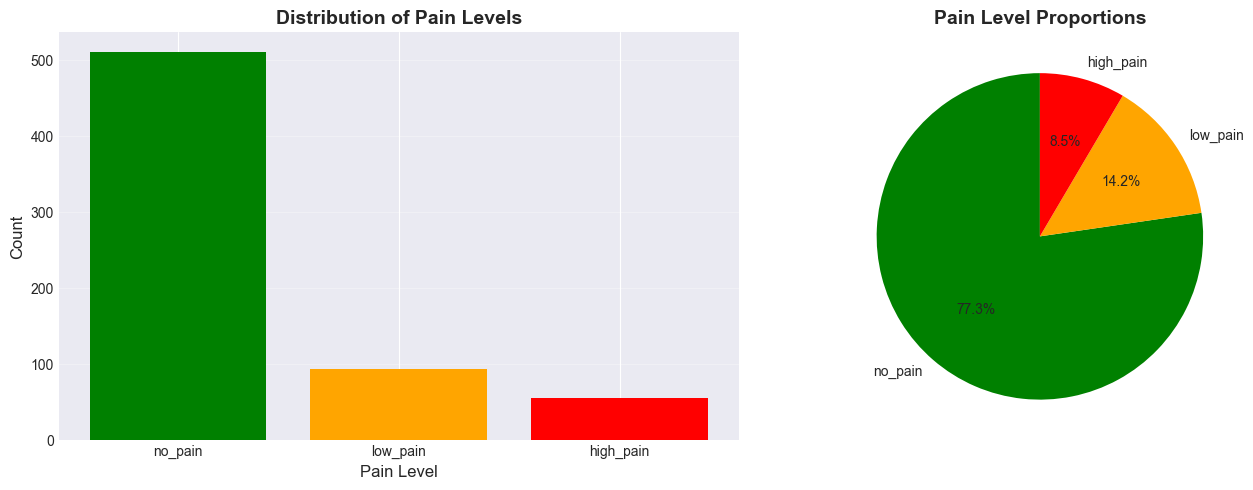


📈 Label Statistics:
label
no_pain      511
low_pain      94
high_pain     56
Name: count, dtype: int64

Class balance: 10.96%


In [175]:
# Label distribution
label_counts = y_train['label'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(label_counts.index, label_counts.values, color=['green', 'orange', 'red'])
axes[0].set_xlabel('Pain Level', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Pain Levels', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
colors = {'no_pain': 'green', 'low_pain': 'orange', 'high_pain': 'red'}
pie_colors = [colors.get(label, 'gray') for label in label_counts.index]
axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=pie_colors)
axes[1].set_title('Pain Level Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📈 Label Statistics:")
print(label_counts)
print(f"\nClass balance: {label_counts.min() / label_counts.max():.2%}")

### Analisi delle feature

Cataloghiamo le colonne rilevanti per le fasi successive di preprocessing.

In [176]:
# Explore feature types
print("\n🔍 Feature Analysis:")
print("=" * 50)

# Identify feature groups
pain_survey_cols = [col for col in X_train.columns if 'pain_survey' in col]
body_char_cols = ['n_legs', 'n_hands', 'n_eyes']
joint_cols = [col for col in X_train.columns if 'joint_' in col]

print(f"\n📋 Pain Survey Features: {len(pain_survey_cols)}")
print(pain_survey_cols)

print(f"\n🧍 Body Characteristics: {len(body_char_cols)}")
print(body_char_cols)

print(f"\n🦴 Joint Measurements: {len(joint_cols)}")
print(f"Joints: joint_00 to joint_{len(joint_cols)-1:02d}")

print(f"\n✅ Total features (excluding sample_index, time): {len(pain_survey_cols) + len(body_char_cols) + len(joint_cols)}")


🔍 Feature Analysis:

📋 Pain Survey Features: 4
['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']

🧍 Body Characteristics: 3
['n_legs', 'n_hands', 'n_eyes']

🦴 Joint Measurements: 31
Joints: joint_00 to joint_30

✅ Total features (excluding sample_index, time): 38


### Visualizzazione di un campione

Osserviamo le serie temporali delle misure per verificare andamenti e range dei segnali.

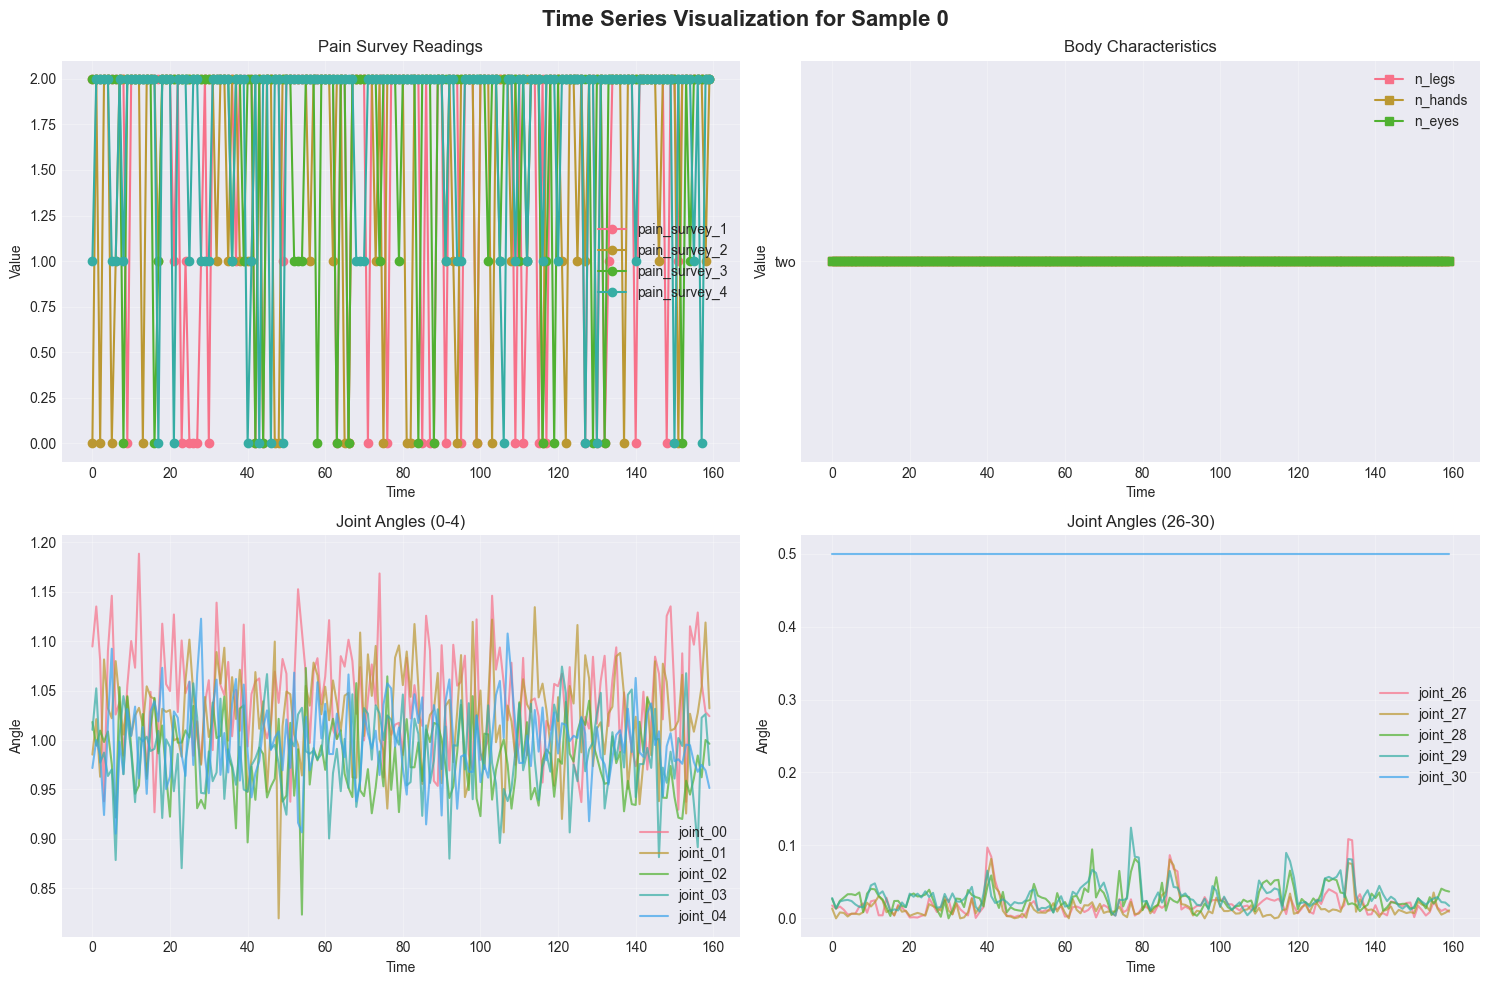

In [177]:
# Visualize a sample time series
sample_idx = 0
sample_data = X_train[X_train['sample_index'] == sample_idx].sort_values('time')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Time Series Visualization for Sample {sample_idx}', fontsize=16, fontweight='bold')

# Pain surveys
for col in pain_survey_cols:
    axes[0, 0].plot(sample_data['time'], sample_data[col], marker='o', label=col)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Value')
axes[0, 0].set_title('Pain Survey Readings')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Body characteristics
for col in body_char_cols:
    if col in sample_data.columns:
        axes[0, 1].plot(sample_data['time'], sample_data[col], marker='s', label=col)
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_title('Body Characteristics')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# First 5 joints
for i, col in enumerate(joint_cols[:5]):
    axes[1, 0].plot(sample_data['time'], sample_data[col], label=col, alpha=0.7)
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Angle')
axes[1, 0].set_title('Joint Angles (0-4)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Last 5 joints
for col in joint_cols[-5:]:
    axes[1, 1].plot(sample_data['time'], sample_data[col], label=col, alpha=0.7)
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Angle')
axes[1, 1].set_title(f'Joint Angles ({len(joint_cols)-5}-{len(joint_cols)-1})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Preprocessing a finestre scorrevoli

Definiamo le utility per pulizia dei segnali, generazione delle finestre e augmentations stocastiche.

In [178]:
# Sliding-window preprocessing and augmentation helpers
WINDOW_SIZE = 60
WINDOW_STRIDE = 30

CATEGORICAL_MAP = {'zero': 0, 'one': 1, 'two': 2, 'three': 3}
CATEGORICAL_COLS = ['n_legs', 'n_hands', 'n_eyes']
PAIN_SURVEY_COLS = [f'pain_survey_{i}' for i in range(1, 5)]
JOINT_COLS = [f'joint_{i:02d}' for i in range(31)]

def map_categorical_features(df):
    for col in CATEGORICAL_COLS:
        if col in df.columns:
            mapped = df[col].map(CATEGORICAL_MAP)
            if mapped.isna().all():
                df[col] = 0.0
            else:
                fill_value = float(mapped.dropna().median()) if not mapped.dropna().empty else 0.0
                df[col] = mapped.fillna(fill_value)
    return df

def interpolate_signals(df):
    joint_cols_present = [col for col in JOINT_COLS if col in df.columns]
    if joint_cols_present:
        df.loc[:, joint_cols_present] = df[joint_cols_present].replace(0, np.nan)
        df.loc[:, joint_cols_present] = df[joint_cols_present].interpolate(method='linear', limit_direction='both', axis=0)
        df.loc[:, joint_cols_present] = df[joint_cols_present].fillna(method='bfill').fillna(method='ffill').fillna(0.0)
    numeric_cols = [col for col in df.columns if col not in ['sample_index', 'time']]
    df.loc[:, numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='both', axis=0)
    df.loc[:, numeric_cols] = df[numeric_cols].fillna(0.0)
    return df

def preprocess_sample(sample_df):
    df = sample_df.sort_values('time').reset_index(drop=True).copy()
    df = map_categorical_features(df)
    df = interpolate_signals(df)
    feature_cols = [col for col in df.columns if col not in ['sample_index', 'time']]
    features = df[feature_cols].to_numpy(dtype=np.float32)
    return features

def create_windows(sequence, window_size=WINDOW_SIZE, stride=WINDOW_STRIDE):
    windows = []
    n_steps, n_features = sequence.shape
    if n_steps <= window_size:
        padded = np.zeros((window_size, n_features), dtype=np.float32)
        padded[:n_steps] = sequence
        windows.append(padded)
        return windows
    start = 0
    while start + window_size <= n_steps:
        windows.append(sequence[start:start + window_size].astype(np.float32))
        start += stride
    if start < n_steps:
        tail = sequence[-window_size:]
        if tail.shape[0] < window_size:
            padded = np.zeros((window_size, n_features), dtype=np.float32)
            padded[:tail.shape[0]] = tail
            windows.append(padded)
        else:
            windows.append(tail.astype(np.float32))
    return windows

def _resample_sequence(seq, target_length):
    if seq.shape[0] == target_length:
        return seq.astype(np.float32)
    original_idx = np.linspace(0, seq.shape[0] - 1, num=seq.shape[0])
    target_idx = np.linspace(0, seq.shape[0] - 1, num=target_length)
    resampled = np.empty((target_length, seq.shape[1]), dtype=np.float32)
    for feature_idx in range(seq.shape[1]):
        resampled[:, feature_idx] = np.interp(target_idx, original_idx, seq[:, feature_idx])
    return resampled

def augment_noise(window, sigma=0.02, rng=None):
    rng = rng or np.random.default_rng()
    noise = rng.normal(0.0, sigma, size=window.shape).astype(np.float32)
    return (window + noise).astype(np.float32)

def augment_scaling(window, scale_range=(0.9, 1.1), rng=None):
    rng = rng or np.random.default_rng()
    scale = rng.uniform(*scale_range)
    return (window * scale).astype(np.float32)

def augment_time_warp(window, stretch_range=(0.8, 1.2), rng=None):
    rng = rng or np.random.default_rng()
    stretch = rng.uniform(*stretch_range)
    target_length = max(2, int(round(window.shape[0] * stretch)))
    stretched = _resample_sequence(window, target_length)
    return _resample_sequence(stretched, window.shape[0])

def augment_dropout(window, drop_range=(0.05, 0.10), rng=None):
    rng = rng or np.random.default_rng()
    drop_ratio = rng.uniform(*drop_range)
    n_drop = max(1, int(round(drop_ratio * window.shape[0])))
    drop_indices = rng.choice(window.shape[0], size=n_drop, replace=False)
    augmented = window.copy()
    augmented[drop_indices] = 0.0
    return augmented.astype(np.float32)

AUGMENTATIONS = ['noise', 'time_warp', 'scaling', 'dropout']

def apply_random_augmentations(window, rng):
    augmented = window.copy()
    n_ops = int(rng.integers(1, len(AUGMENTATIONS) + 1))
    chosen = rng.choice(AUGMENTATIONS, size=n_ops, replace=False)
    for op in chosen:
        if op == 'noise':
            augmented = augment_noise(augmented, sigma=0.02, rng=rng)
        elif op == 'time_warp':
            augmented = augment_time_warp(augmented, stretch_range=(0.8, 1.2), rng=rng)
        elif op == 'scaling':
            augmented = augment_scaling(augmented, scale_range=(0.9, 1.1), rng=rng)
        elif op == 'dropout':
            augmented = augment_dropout(augmented, drop_range=(0.05, 0.10), rng=rng)
    return augmented.astype(np.float32)

print("✅ Sliding-window preprocessing utilities ready!")

✅ Sliding-window preprocessing utilities ready!


## 3. Costruzione del dataset a finestre

Convertiamo i segnali grezzi in tensori uniformi, applichiamo lo scaling e generiamo le finestre augmentate.

In [179]:
# Build sliding-window dataset with augmentations
print("🔄 Building sliding-window dataset...")

rng = np.random.default_rng(42)
windows = []
window_labels = []

sample_indices = X_train['sample_index'].unique()

for sample_idx in sample_indices:
    sample_data = X_train[X_train['sample_index'] == sample_idx].copy()
    processed = preprocess_sample(sample_data)
    sample_windows = create_windows(processed, window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)
    label = y_train[y_train['sample_index'] == sample_idx]['label'].iloc[0]
    windows.extend(sample_windows)
    window_labels.extend([label] * len(sample_windows))

total_windows = len(windows)
feature_dim = windows[0].shape[1] if windows else 0
print(f"✅ Generated {total_windows} windows")
print(f"   Window size: {WINDOW_SIZE} | Stride: {WINDOW_STRIDE}")
print(f"   Feature dimensionality: {feature_dim}")

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(window_labels)

windows_array = np.stack(windows).astype(np.float32)
labels_array = encoded_labels.astype(np.int32)

X_train_seq, X_val_seq, y_train_enc, y_val_enc = train_test_split(
    windows_array,
    labels_array,
    test_size=0.2,
    random_state=42,
    stratify=labels_array
 )
y_train_enc = y_train_enc.astype(np.int32)
y_val_enc = y_val_enc.astype(np.int32)

print(f"🧱 Training windows before augmentation: {X_train_seq.shape[0]}")
print(f"🧱 Validation windows: {X_val_seq.shape[0]}")

scaler = StandardScaler()
train_flat = X_train_seq.reshape(-1, feature_dim)
val_flat = X_val_seq.reshape(-1, feature_dim)
scaler.fit(train_flat)
X_train_seq = scaler.transform(train_flat).reshape(-1, WINDOW_SIZE, feature_dim).astype(np.float32)
X_val_seq = scaler.transform(val_flat).reshape(-1, WINDOW_SIZE, feature_dim).astype(np.float32)

train_count_before_aug = X_train_seq.shape[0]
augmented_windows = list(X_train_seq)
augmented_labels = list(y_train_enc)

for window, label in zip(X_train_seq, y_train_enc):
    if rng.random() < 0.5:
        augmented = apply_random_augmentations(window, rng)
        augmented_windows.append(augmented)
        augmented_labels.append(label)

X_train_seq = np.stack(augmented_windows).astype(np.float32)
y_train_enc = np.asarray(augmented_labels, dtype=np.int32)

print(f"✨ Training windows after augmentation: {X_train_seq.shape[0]} (Δ {X_train_seq.shape[0] - train_count_before_aug})")

sequence_length = WINDOW_SIZE
n_features = feature_dim

print(f"📐 Final tensor shapes → X_train: {X_train_seq.shape}, X_val: {X_val_seq.shape}")

🔄 Building sliding-window dataset...
✅ Generated 3305 windows
   Window size: 60 | Stride: 30
   Feature dimensionality: 38
🧱 Training windows before augmentation: 2644
🧱 Validation windows: 661
✨ Training windows after augmentation: 3974 (Δ 1330)
📐 Final tensor shapes → X_train: (3974, 60, 38), X_val: (661, 60, 38)


### Statistiche sulle etichette

Valutiamo la distribuzione delle classi dopo la fase di augmentazione e suddivisione.

In [180]:
# Label encoding overview
class_counts = pd.Series(y_train_enc).value_counts().sort_index()
print("\n🏷️ Label Encoding:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"   {label} → {idx}")

print("\nClass distribution (training after augmentation):")
for cls_idx, count in class_counts.items():
    print(f"   Class {cls_idx} ({label_encoder.classes_[cls_idx]}): {count}")

val_counts = pd.Series(y_val_enc).value_counts().sort_index()
print("\nClass distribution (validation):")
for cls_idx, count in val_counts.items():
    print(f"   Class {cls_idx} ({label_encoder.classes_[cls_idx]}): {count}")


🏷️ Label Encoding:
   high_pain → 0
   low_pain → 1
   no_pain → 2

Class distribution (training after augmentation):
   Class 0 (high_pain): 352
   Class 1 (low_pain): 566
   Class 2 (no_pain): 3056

Class distribution (validation):
   Class 0 (high_pain): 56
   Class 1 (low_pain): 94
   Class 2 (no_pain): 511


### Persistenza dei tensori base

Manteniamo copie numpy dei tensori di train e validation per facilitare gli esperimenti successivi.

In [181]:
# Persist base tensors for downstream experiments
print("\n💾 Storing base training tensors...")

X_train_base = X_train_seq.astype(np.float32)
y_train_base = y_train_enc.copy()
X_val_base = X_val_seq.astype(np.float32)
y_val_base = y_val_enc.copy()

print(f"Training base shape: {X_train_base.shape}")
print(f"Validation base shape: {X_val_base.shape}")


💾 Storing base training tensors...
Training base shape: (3974, 60, 38)
Validation base shape: (661, 60, 38)


## 4. Metriche e callback

Definiamo la metrica personalizzata F1 macro per il monitoraggio durante l'addestramento.

In [182]:
# Custom F1-Score Metric for Keras
class F1Score(keras.metrics.Metric):
    """
    Custom F1-Score metric for Keras
    Computes macro-averaged F1-score for multi-class classification
    """
    def __init__(self, name='f1_score', num_classes=3, **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred_classes = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        
        y_true_one_hot = tf.cast(tf.one_hot(y_true, depth=self.num_classes), tf.float32)
        y_pred_one_hot = tf.cast(tf.one_hot(y_pred_classes, depth=self.num_classes), tf.float32)
        
        if sample_weight is not None:
            sample_weight = tf.cast(tf.reshape(sample_weight, [-1, 1]), tf.float32)
            y_true_one_hot *= sample_weight
            y_pred_one_hot *= sample_weight
        
        tp = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=0)
        fp = tf.reduce_sum((1.0 - y_true_one_hot) * y_pred_one_hot, axis=0)
        fn = tf.reduce_sum(y_true_one_hot * (1.0 - y_pred_one_hot), axis=0)
        
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)
    
    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return tf.reduce_mean(f1)
    
    def reset_state(self):
        self.true_positives.assign(tf.zeros((self.num_classes,)))
        self.false_positives.assign(tf.zeros((self.num_classes,)))
        self.false_negatives.assign(tf.zeros((self.num_classes,)))

print("✅ F1-Score metric class defined!")

✅ F1-Score metric class defined!


### Metadati per l'addestramento

Raccogliamo informazioni chiave sul problema per configurare i modelli.

In [183]:
# Model metadata
n_classes = len(label_encoder.classes_)
print("🏗️ Model metadata prepared.")
print(f"Number of classes: {n_classes}")
print(f"Sequence length: {sequence_length}")
print(f"Features per timestep: {n_features}")

🏗️ Model metadata prepared.
Number of classes: 3
Sequence length: 60
Features per timestep: 38


### Callback di addestramento

Utilizziamo early stopping e riduzione del learning rate per favorire la generalizzazione.

In [184]:
# Define callbacks factory
def create_callbacks():
    return [
        keras.callbacks.EarlyStopping(
            monitor='val_f1_score',
            patience=10,
            mode='max',
            restore_best_weights=True,
            verbose=0
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_f1_score',
            factor=0.5,
            patience=5,
            mode='max',
            min_lr=1e-6,
            verbose=0
        )
    ]

print("✅ Callback factory ready!")

✅ Callback factory ready!


### Utility per i pesi di classe

Calcoliamo pesi bilanciati da fornire a Keras per mitigare lo sbilanciamento delle etichette.

In [185]:
# Training utilities aligned with sliding-window approach
def compute_balanced_class_weights(labels):
    """Calcola pesi bilanciati da passare a Keras per gestire lo sbilanciamento delle classi."""
    classes = np.unique(labels)
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    return {int(cls): float(weight) for cls, weight in zip(classes, weights)}

## 5. Ricerca di modelli sequenziali

Configuriamo la griglia di esperimenti (LSTM/GRU/CNN-LSTM) e monitoriamo l'avanzamento con tqdm.

In [ ]:
# %% ⚡ ENSEMBLE GRID SEARCH (LSTM, GRU, CNN-LSTM)
from contextlib import contextmanager
import joblib
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("🚀 Starting Ensemble Grid Search...")

# =====================================================
# 1. MODEL BUILDERS
# =====================================================
def build_lstm(sequence_length, n_features, n_classes, units=(128, 64), dense_units=(64,), dropout=0.3, dense_dropout=None, recurrent_dropout=0.0):
    dense_dropout = dropout if dense_dropout is None else dense_dropout
    model = keras.Sequential()
    model.add(layers.Input(shape=(sequence_length, n_features)))
    for idx, unit_count in enumerate(units):
        return_sequences = idx < len(units) - 1
        model.add(layers.LSTM(unit_count, return_sequences=return_sequences, recurrent_dropout=recurrent_dropout))
        model.add(layers.Dropout(dropout))
        if return_sequences:
            model.add(layers.BatchNormalization())
    for idx, dense_count in enumerate(dense_units):
        model.add(layers.Dense(dense_count, activation='relu'))
        if dense_dropout > 0:
            model.add(layers.Dropout(dense_dropout))
    model.add(layers.Dense(n_classes, activation='softmax'))
    return model

def build_gru(sequence_length, n_features, n_classes, units=(128, 64), dropout=0.3):
    model = keras.Sequential([
        layers.Input(shape=(sequence_length, n_features)),
        layers.GRU(units[0], return_sequences=True),
        layers.Dropout(dropout),
        layers.GRU(units[1]),
        layers.Dropout(dropout),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

def build_cnn_lstm(sequence_length, n_features, n_classes, filters=64, kernel_size=3, lstm_units=64, dropout=0.3):
    model = keras.Sequential([
        layers.Input(shape=(sequence_length, n_features)),
        layers.Conv1D(filters, kernel_size, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.LSTM(lstm_units),
        layers.Dropout(dropout),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model


# =====================================================
# 2. MODEL WRAPPER for grid search
# =====================================================
def build_generic_model(model_type, **kwargs):
    if model_type == "LSTM":
        return build_lstm(**kwargs)
    if model_type == "GRU":
        return build_gru(**kwargs)
    if model_type == "CNN_LSTM":
        return build_cnn_lstm(**kwargs)
    raise ValueError(f"Unknown model_type: {model_type}")


# =====================================================
# 3. PARAMETER SPACE
# =====================================================
model_param_grid = [
    # 🔹 Baseline vincente (per confronto)
    {
        'model_type': 'LSTM',
        'units': (256, 128, 64),
        'dropout': 0.25,
        'learning_rate': 7e-4
    },

    # 🔸 Più profondo e leggermente più regolarizzato
    {
        'model_type': 'LSTM',
        'units': (320, 160, 80, 40),
        'dropout': 0.3,
        'learning_rate': 6e-4
    },

    # 🔸 Stessa profondità, ma dropout più basso (meno regolarizzazione)
    {
        'model_type': 'LSTM',
        'units': (256, 128, 64),
        'dropout': 0.15,
        'learning_rate': 8e-4
    },

    # 🔹 Aggiungo dense head per combinare feature
    {
        'model_type': 'LSTM',
        'units': (256, 128, 64),
        'dense_units': (128,),
        'dropout': 0.25,
        'learning_rate': 9e-4
    },

    # 🔸 Più snello ma con stessa gerarchia
    {
        'model_type': 'LSTM',
        'units': (192, 96, 48),
        'dropout': 0.25,
        'learning_rate': 1e-3
    },

    # 🔹 Architettura piramidale invertita (espande poi riduce)
    {
        'model_type': 'LSTM',
        'units': (128, 256, 128),
        'dropout': 0.3,
        'learning_rate': 7e-4
    },

    # 🔸 Meno layer, più unità (approccio largo)
    {
        'model_type': 'LSTM',
        'units': (384, 192),
        'dropout': 0.2,
        'learning_rate': 5e-4
    },

    # 🔹 Variante stabile con più dropout e dense layer
    {
        'model_type': 'LSTM',
        'units': (256, 128, 64),
        'dense_units': (64,),
        'dropout': 0.35,
        'learning_rate': 6e-4
    },

    # 🔸 Più piccolo, learning rate più alto per testare generalizzazione
    {
        'model_type': 'LSTM',
        'units': (160, 80, 40),
        'dropout': 0.25,
        'learning_rate': 1.2e-3
    },
]
training_params = {'epochs': 60, 'batch_size': 512}
balanced_class_weights = compute_balanced_class_weights(y_train_base)


# =====================================================
# Helper: progress bar for joblib
# =====================================================
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    original_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = original_callback
        tqdm_object.close()


# =====================================================
# 4. EXPERIMENT FUNCTION (wrapper)
# =====================================================
def run_single_experiment(model_params):
    model_params_local = model_params.copy()
    model_type = model_params_local.pop("model_type")
    learning_rate = model_params_local.pop("learning_rate", 1e-3)
    dropout = model_params_local.pop("dropout", 0.3)

    build_args = dict(
        sequence_length=sequence_length,
        n_features=n_features,
        n_classes=n_classes
    )

    model = build_generic_model(
        model_type,
        **build_args,
        dropout=dropout,
        **model_params_local
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', F1Score(num_classes=n_classes)]
    )

    history = model.fit(
        X_train_base, y_train_base,
        validation_data=(X_val_seq, y_val_enc),
        epochs=training_params['epochs'],
        batch_size=training_params['batch_size'],
        callbacks=create_callbacks(),
        class_weight=balanced_class_weights,
        verbose=0
    )

    val_pred_probs = model.predict(X_val_seq, verbose=0)
    y_pred = np.argmax(val_pred_probs, axis=1)
    f1_macro = f1_score(y_val_enc, y_pred, average='macro')
    acc = np.mean(y_val_enc == y_pred)

    history_dict = history.history
    val_f1_history = history_dict.get('val_f1_score')
    best_epoch = int(np.argmax(val_f1_history)) if val_f1_history is not None else None
    best_val_f1 = float(max(val_f1_history)) if val_f1_history is not None else None

    model_config = {**model_params_local}
    model_config['model_type'] = model_type
    model_config['dropout'] = dropout
    model_config['learning_rate'] = learning_rate

    result = {
        'model_type': model_type,
        'model_config': model_config,
        'val_f1_macro': f1_macro,
        'val_accuracy': acc,
        'val_pred_probs': val_pred_probs.astype(np.float32),
        'epochs_trained': len(history_dict.get('loss', [])),
        'best_epoch': best_epoch,
        'val_f1_keras_best': best_val_f1
    }

    tf.keras.backend.clear_session()
    del model

    return result


# =====================================================
# 5. PARALLEL GRID SEARCH
# =====================================================
total_jobs = len(model_param_grid)
with tqdm_joblib(tqdm(total=total_jobs, desc="Training models", unit="model")):
    grid_results = Parallel(n_jobs=-1)(
        delayed(run_single_experiment)(m)
        for m in model_param_grid
    )


# =====================================================
# 6. ENSEMBLE (Weighted Voting)
# =====================================================
print("\n🧠 Creating ensemble predictions (weighted voting)...")
preds = []
weights = []

for res in grid_results:
    pred_probs = res['val_pred_probs']
    preds.append(pred_probs)
    weights.append(max(res['val_f1_macro'], 1e-6))

ensemble_pred = np.average(preds, axis=0, weights=weights)
ensemble_classes = np.argmax(ensemble_pred, axis=1)

ensemble_f1 = f1_score(y_val_enc, ensemble_classes, average='macro')
ensemble_acc = np.mean(ensemble_classes == y_val_enc)


# =====================================================
# 7. RESULTS SUMMARY
# =====================================================
grid_results_df = pd.DataFrame([
    {
        'model_type': r['model_type'],
        'val_f1_macro': r['val_f1_macro'],
        'val_accuracy': r['val_accuracy'],
    }
    for r in grid_results
])

print("\n📊 Individual model results:")
display(grid_results_df.sort_values('val_f1_macro', ascending=False))

print("\n🥇 ENSEMBLE PERFORMANCE")
print(f"F1-macro (ensemble): {ensemble_f1:.4f}")
print(f"Accuracy (ensemble): {ensemble_acc:.4f}")

best_single_result_raw = max(grid_results, key=lambda r: r['val_f1_macro'])
best_single_result = best_single_result_raw.copy()
best_single_result.pop('val_pred_probs', None)
best_model_config = best_single_result['model_config'].copy()

print("\n🏆 Best single model:")
print(
    f"Type: {best_single_result['model_type']} | "
    f"Macro F1: {best_single_result['val_f1_macro']:.4f} | "
    f"Accuracy: {best_single_result['val_accuracy']:.4f}"
 )
print(f"Hyperparameters: {best_model_config}")

🚀 Starting Ensemble Grid Search...


Training models:   0%|          | 0/9 [00:00<?, ?model/s]python(8575) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8576) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8577) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8578) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8579) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8580) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8581) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8582) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8584) MallocStackLogging: can't turn off malloc stack logging b

## 6. Rifinitura del modello migliore

Rialleniamo la migliore configurazione per più epoche e ne misuriamo le metriche di validazione.

In [ ]:
# Retrain best configuration to capture full artifacts
print("🎯 Retraining best configuration for detailed evaluation...")
if 'best_single_result' not in globals():
    raise RuntimeError("Esegui prima la cella di grid search per determinare la configurazione migliore.")

refit_epochs = 80
best_model_config = best_single_result['model_config'].copy()
best_model_type = best_model_config.pop('model_type')
best_learning_rate = best_model_config.pop('learning_rate', 1e-3)
best_dropout = best_model_config.pop('dropout', 0.3)
best_model_summary = {
    'model_type': best_model_type,
    **best_model_config,
    'dropout': best_dropout,
    'learning_rate': best_learning_rate
}
print(f"Configurazione selezionata: {best_model_summary}")

# Costruisci e riallena il modello con più epoche
best_model = build_generic_model(
    best_model_type,
    sequence_length=sequence_length,
    n_features=n_features,
    n_classes=n_classes,
    dropout=best_dropout,
    **best_model_config
 )
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', F1Score(num_classes=n_classes)]
 )

best_history_obj = best_model.fit(
    X_train_base,
    y_train_base,
    validation_data=(X_val_seq, y_val_enc),
    epochs=refit_epochs,
    batch_size=training_params['batch_size'],
    callbacks=create_callbacks(),
    class_weight=balanced_class_weights,
    verbose=0
 )
best_history = best_history_obj.history

# Calcola metriche sulla validation
y_val_pred = np.argmax(best_model.predict(X_val_seq, verbose=0), axis=1)
val_f1_macro = f1_score(y_val_enc, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_val_enc, y_val_pred, average='weighted')
val_accuracy = np.mean(y_val_pred == y_val_enc)

print(
    f"Macro F1: {val_f1_macro:.4f} | "
    f"Weighted F1: {val_f1_weighted:.4f} | "
    f"Accuracy: {val_accuracy:.4f}"
)

🎯 Retraining best configuration for detailed evaluation...
Configurazione selezionata: {'model_type': 'LSTM', 'units': (256, 128, 64), 'dropout': 0.25, 'learning_rate': 0.0007}
Macro F1: 0.9554 | Weighted F1: 0.9787 | Accuracy: 0.9788


### Andamento dell'addestramento

Tracciamo loss, accuracy e F1 per monitorare il comportamento del modello rifinito.

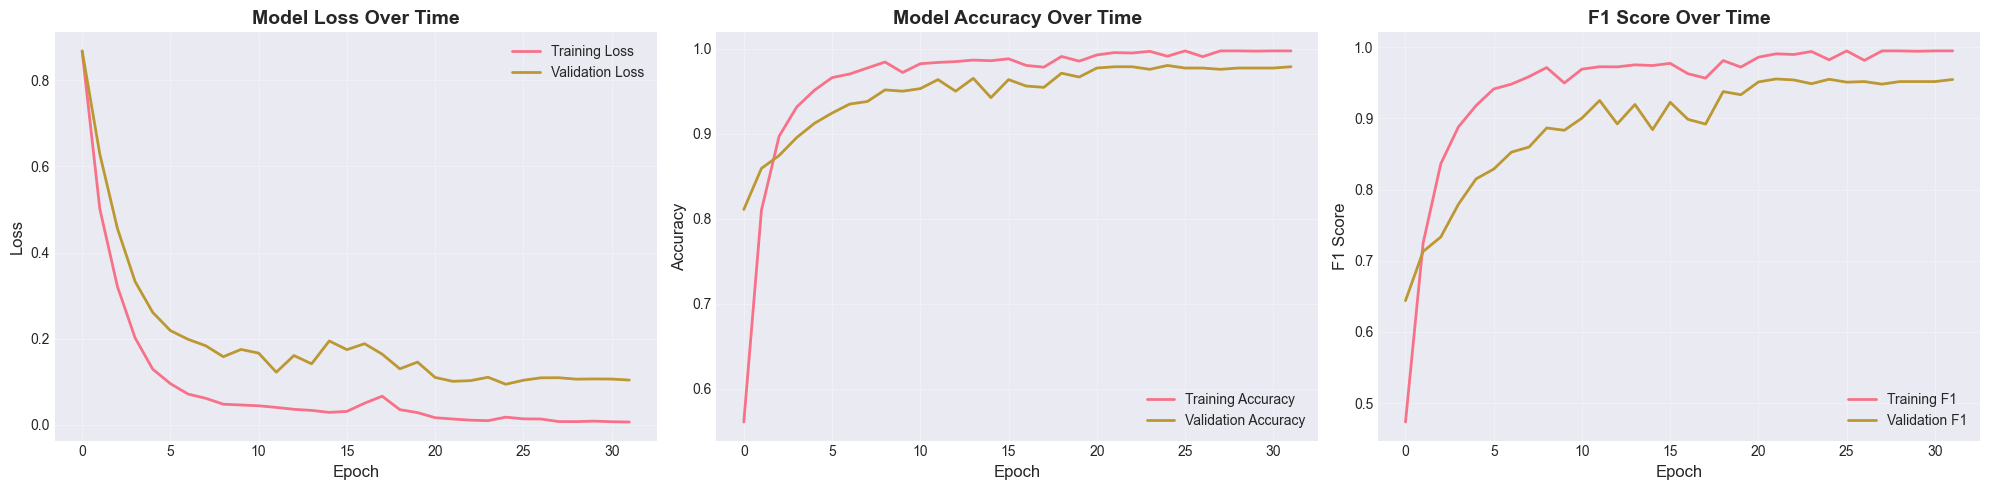


📊 Final Training Metrics (Best Configuration):
Training Loss: 0.0065
Training Accuracy: 0.9975
Validation Loss: 0.1040
Validation Accuracy: 0.9788
Validation F1: 0.9546


In [ ]:
# Visualize training history of the best configuration
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Loss
axes[0].plot(best_history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(best_history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(best_history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(best_history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# F1 score
axes[2].plot(best_history['f1_score'], label='Training F1', linewidth=2)
axes[2].plot(best_history['val_f1_score'], label='Validation F1', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('F1 Score', fontsize=12)
axes[2].set_title('F1 Score Over Time', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n📊 Final Training Metrics (Best Configuration):")
print("=" * 50)
print(f"Training Loss: {best_history['loss'][-1]:.4f}")
print(f"Training Accuracy: {best_history['accuracy'][-1]:.4f}")
print(f"Validation Loss: {best_history['val_loss'][-1]:.4f}")
print(f"Validation Accuracy: {best_history['val_accuracy'][-1]:.4f}")
print(f"Validation F1: {best_history['val_f1_score'][-1]:.4f}")

### Valutazione su validation

Calcoliamo metriche di classificazione e report completo sul validation set.

In [ ]:
# Make predictions on validation set with the best model
print("🔮 Evaluating best model on validation set...\n")

y_pred_probs = best_model.predict(X_val_seq)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calculate F1-scores
f1_macro = f1_score(y_val_enc, y_pred_classes, average='macro')
f1_weighted = f1_score(y_val_enc, y_pred_classes, average='weighted')
f1_per_class = f1_score(y_val_enc, y_pred_classes, average=None)

print("🎯 F1-SCORE RESULTS (PRIMARY METRIC):")
print("=" * 50)
print(f"Macro F1-Score:    {f1_macro:.4f} ⭐")
print(f"Weighted F1-Score: {f1_weighted:.4f}")
print("\nF1-Score per class:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label:15s}: {f1_per_class[i]:.4f}")
print("\n" + "=" * 50)

# Classification report
print("📋 Classification Report:")
print("=" * 70)
print(classification_report(y_val_enc, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Overall accuracy
accuracy = np.mean(y_pred_classes == y_val_enc)
print(f"\n✨ Overall Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

🔮 Evaluating best model on validation set...

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
🎯 F1-SCORE RESULTS (PRIMARY METRIC):
Macro F1-Score:    0.9554 ⭐
Weighted F1-Score: 0.9787

F1-Score per class:
  high_pain      : 0.9107
  low_pain       : 0.9670
  no_pain        : 0.9883

📋 Classification Report:
              precision    recall  f1-score   support

   high_pain       0.91      0.91      0.91        56
    low_pain       1.00      0.94      0.97        94
     no_pain       0.98      0.99      0.99       511

    accuracy                           0.98       661
   macro avg       0.96      0.95      0.96       661
weighted avg       0.98      0.98      0.98       661


✨ Overall Validation Accuracy: 0.9788 (97.88%)


### Confusion matrix e analisi errori

Ispezioniamo il dettaglio delle predizioni per classe per individuare pattern di errore.

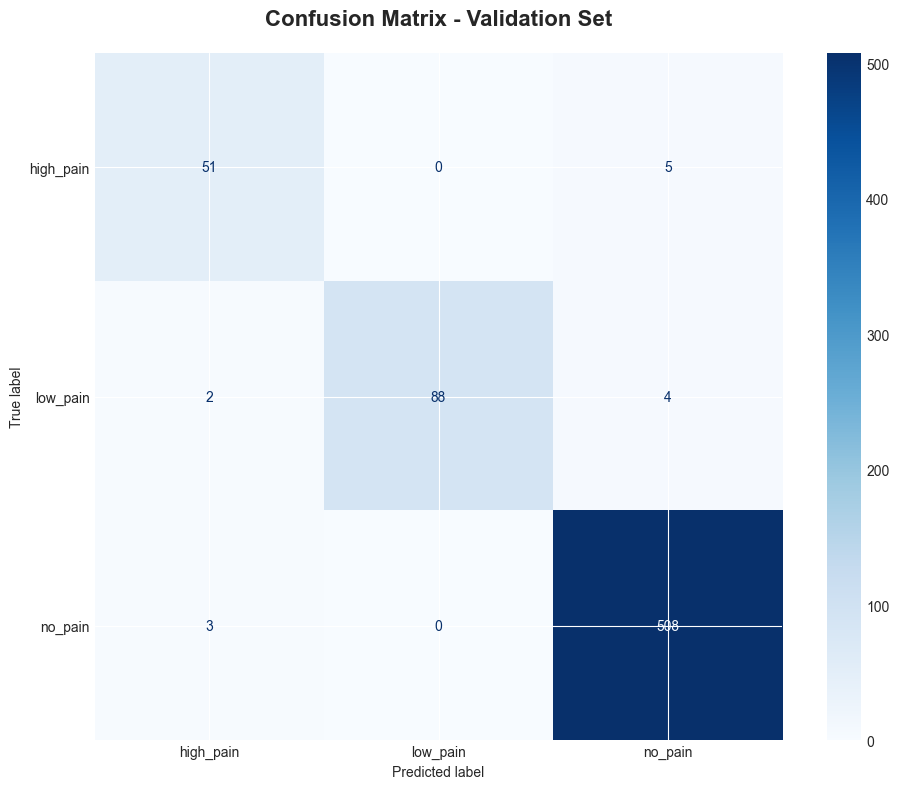


🔍 Confusion Matrix Analysis:
high_pain:
  Correct: 51/56 (91.1%)
  Misclassified: 5
low_pain:
  Correct: 88/94 (93.6%)
  Misclassified: 6
no_pain:
  Correct: 508/511 (99.4%)
  Misclassified: 3


In [ ]:
# Confusion matrix
cm = confusion_matrix(y_val_enc, y_pred_classes)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Confusion Matrix - Validation Set', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Detailed confusion matrix analysis
print("\n🔍 Confusion Matrix Analysis:")
print("=" * 50)
for i, label in enumerate(label_encoder.classes_):
    total = cm[i].sum()
    correct = cm[i, i]
    print(f"{label}:")
    print(f"  Correct: {correct}/{total} ({correct/total*100:.1f}%)")
    print(f"  Misclassified: {total-correct}")

## 7. Preparazione del test set

Carichiamo i dati di test e ne verifichiamo struttura e campioni principali.

In [ ]:
# Load test data
print("📂 Loading test data...")
X_test = pd.read_csv('pirate_pain_test.csv')

print(f"Test data shape: {X_test.shape}")
print(f"Number of test samples: {X_test['sample_index'].nunique()}")
print("\n📊 First few rows:")
display(X_test.head())

📂 Loading test data...
Test data shape: (211840, 40)
Number of test samples: 1324

📊 First few rows:


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,2,2,2,two,two,two,0.842535,...,0.000003,0.000004,0.000003,0.000003,0.000068,0.019372,0.066324,0.022228,0.013576,0.5
1,0,1,2,2,2,2,two,two,two,0.898836,...,0.000003,0.000004,0.000004,0.000003,0.000029,0.069747,0.080417,0.023650,0.038793,0.5
2,0,2,2,2,2,2,two,two,two,0.957765,...,0.000006,0.000004,0.000009,0.000004,0.000008,0.054968,0.058811,0.027023,0.054202,0.5
3,0,3,1,2,2,2,two,two,two,0.832596,...,0.000005,0.000004,0.000003,0.000004,0.000015,0.048695,0.047128,0.016151,0.024983,0.5
4,0,4,2,2,2,0,two,two,two,0.805971,...,0.000006,0.000004,0.000003,0.000003,0.000008,0.019762,0.031116,0.015618,0.017931,0.5


### Generazione delle finestre di test

Applichiamo lo stesso preprocessing su ciascun campione del test set.

In [ ]:
# Prepare test windows
print("\n🔄 Preparing test windows...")

test_windows = []
test_window_sample_indices = []

unique_test_samples = X_test['sample_index'].unique()

for sample_idx in unique_test_samples:
    sample_data = X_test[X_test['sample_index'] == sample_idx].copy()
    processed = preprocess_sample(sample_data)
    sample_windows = create_windows(processed, window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)
    for window in sample_windows:
        test_windows.append(window.astype(np.float32))
        test_window_sample_indices.append(sample_idx)

if not test_windows:
    raise ValueError("Nessuna finestra generata dal set di test.")

test_windows_array = np.stack(test_windows).astype(np.float32)
test_windows_flat = test_windows_array.reshape(-1, n_features)
test_windows_scaled = scaler.transform(test_windows_flat).reshape(-1, WINDOW_SIZE, n_features).astype(np.float32)

print(f"✅ Created {len(test_windows_scaled)} test windows from {len(unique_test_samples)} samples")
print(f"   Window shape: {test_windows_scaled.shape[1:]}")
print(f"   Unique sample indices: {len(set(test_window_sample_indices))}")


🔄 Preparing test windows...
✅ Created 6620 test windows from 1324 samples
   Window shape: (60, 38)
   Unique sample indices: 1324


### Predizione aggregata sul test

Otteniamo le probabilità per finestra, le aggreghiamo a livello di campione e analizziamo la distribuzione finale.


🔮 Generating predictions...
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
✅ Generated predictions for 1324 samples

📊 Prediction distribution:
no_pain      1043
low_pain      181
high_pain     100
Name: count, dtype: int64


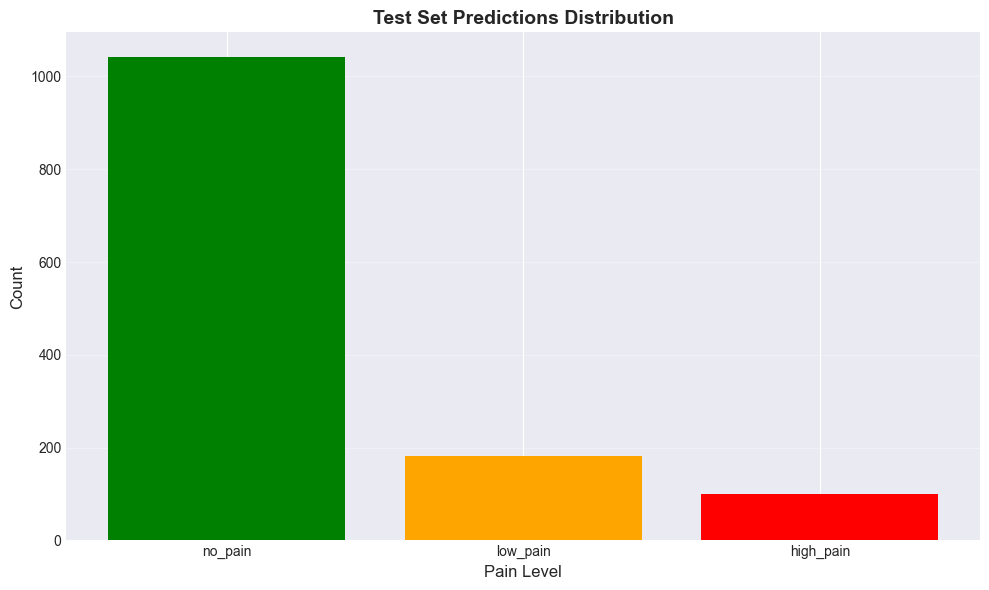

In [ ]:
# Make predictions
print("\n🔮 Generating predictions...")

window_probs = best_model.predict(test_windows_scaled)

sample_probabilities = defaultdict(list)
for prob, sample_idx in zip(window_probs, test_window_sample_indices):
    sample_probabilities[sample_idx].append(prob)

aggregated_indices = []
aggregated_probs = []
for sample_idx in unique_test_samples:
    probs = np.stack(sample_probabilities[sample_idx])
    aggregated_indices.append(sample_idx)
    aggregated_probs.append(probs.mean(axis=0))

aggregated_probs = np.stack(aggregated_probs)
y_test_classes = np.argmax(aggregated_probs, axis=1)
y_test_labels = label_encoder.inverse_transform(y_test_classes)

print(f"✅ Generated predictions for {len(y_test_labels)} samples")

# Show prediction distribution
pred_dist = pd.Series(y_test_labels).value_counts()
print("\n📊 Prediction distribution:")
print(pred_dist)

# Visualize
plt.figure(figsize=(10, 6))
colors_map = {'no_pain': 'green', 'low_pain': 'orange', 'high_pain': 'red'}
bar_colors = [colors_map.get(label, 'gray') for label in pred_dist.index]
plt.bar(pred_dist.index, pred_dist.values, color=bar_colors)
plt.xlabel('Pain Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Test Set Predictions Distribution', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Esportazione della submission

Formattiamo gli indici e salviamo il file `submission.csv` conforme alle specifiche della competizione.

In [ ]:
# Save submission
formatted_indices = [f"{int(idx):03d}" for idx in aggregated_indices]
submission_df = pd.DataFrame({
    'sample_index': formatted_indices,
    'label': y_test_labels
}).sort_values('sample_index').reset_index(drop=True)
submission_path = os.path.join(os.getcwd(), 'submission.csv')
submission_df.to_csv(submission_path, index=False)
print(f"✅ Submission saved to {submission_path}")

✅ Submission saved to /Users/gabrielecarta/Documents/GitHub/challenge_an2dl/submission.csv
